<br>

# Notebook 2 - Crop Simulation

<hr>
This key module simulates all the possible crop cycles to  find the best crop cycle that produces maximum yield for a particular grid. During the simulation process for each grid, 365 crop cycle simulations are performed. Each simulation corresponds to cycles that start from each day of the year (starting from Julian date 0 to Julian date 365). Similarly, this process is performed by the program for each grid in the study area. 

Prepared by Geoinformatics Center, AIT
<hr>


### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys

Setting the working directory -- where our PyAEZ project is located.

In [7]:
'Set the working directory'
work_dir = r'D:\PyAEZv2.1_Draft'  # Please change this to your working directory
os.chdir(work_dir)
sys.path.append('./pyaez/')
os.getcwd()


Check and create data output folder

In [4]:
import os
folder_path = './data_output/NB2/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Folder created successfully.")
else:
    print("Folder already exists.")


Folder already exists.


<hr>

## MODULE 2: CROP SIMULATION
Now, we will start executing the routines in Module 2


First, we initiate Module 2 Class instance by invoking the following commands:

In [5]:
'''importing library'''


from pyaez import CropSimulation, UtilitiesCalc

%load_ext autoreload
%autoreload 2
# Import Module 2 and initate Class intance

aez = CropSimulation.CropSimulation()

obj_util = UtilitiesCalc.UtilitiesCalc()


### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m^2
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
- Soil/terrain/special land cover classes
  

**All the datasets must have the same shape.**


## Reading Data

In [11]:
'''reading climate data'''
# Importing the climate data
max_temp = np.load(r'./data_input/climate/max_temp.npy')# maximum temperature
min_temp = np.load(r'./data_input/climate/min_temp.npy')  # minimum temperature
precipitation = np.load(r'./data_input/climate/precipitation.npy')  # precipitation
rel_humidity = np.load(r'./data_input/climate/relative_humidity.npy') # relative humidity
wind_speed = np.load(r'./data_input/climate/wind_speed.npy')# wind speed measured at two meters
short_rad = np.load(r'./data_input/climate/short_rad.npy') # shortwave radiation

# Load the geographical data/rasters
mask_path = './data_input/LAO_Admin.tif'
mask = gdal.Open(mask_path).ReadAsArray()
elevation = gdal.Open(r'./data_input/LAO_Elevation.tif').ReadAsArray()
soil_terrain_lulc = gdal.Open(r'./data_input/LAO_soil_terrain_lulc.tif').ReadAsArray()


This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)

In [12]:
# Define the Area-Of-Interest's geographical extents
lat_min = 13.87
lat_max = 22.59
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
daily = False #Type of climate data = True: daily, False: monthly

### Loading the imported data into the Object Class ('*aez*' Class)

In [13]:
aez.setStudyAreaMask(mask, mask_value)
aez.setLocationTerrainData(lat_min, lat_max, elevation)
if daily:
    aez.setDailyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
else:
    aez.setMonthlyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)


### Setting up the crop parameter/ crop cycle parameter and soil water parameters (Mandatory)

In [14]:
# setting up the crop parameters, crop cycle and soil water parameters ***mandatory step
# New function, reading crop-specific biomass/yield loss/TSUM screening factors from excel sheet, xlsx file.
aez.readCropandCropCycleParameters(file_path = r'./data_input/input_crop_TSUM_parameters_maiz_sugar.xlsx', 
                                   crop_name = 'sugarcane')


aez.setSoilWaterParameters(Sa= 100*np.ones((mask.shape)), pc=0.5)

### Setting up the thermal screening parameters (Optional)

In [15]:
# If you're simulating perennial crops, this thermal screening is mandatory
# Compute Thermal Climate
tclimate = aez.getThermalClimate()

# Compute permafrost
permafrost_eval = aez.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost_class = permafrost_eval[1]
# tclimate = gdal.Open("./data_output/NB1/LAO_ThermalClimate.tif").ReadAsArray()# User to change this TClimate file 
# permafrost_class = gdal.Open("./data_output/NB1/LAO_permafrost.tif").ReadAsArray()# User to change this permafrost file

# Thermal Climate screening
aez.setThermalClimateScreening(tclimate, no_t_climate=[2,6,7,8,9,10,11,12])

# New Thermal Screening: Permafrost Screening
aez.setPermafrostScreening(permafrost_class= permafrost_class)

# Updated Temperature Profile screenign routine
aez.setupTypeBConstraint(file_path = r'./data_input/crop-specific_rule_maiz_sugar.xlsx', 
                         crop_name = 'sugarcane')


c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\git_clone_pyaez_development\PyAEZ\pyaez\CropSimulation.py:1221: RuntimeWarning: invalid value encountered in true_divide
  fi = np.sqrt(ddf)/(np.sqrt(ddf) + np.sqrt(ddt))


### Perennial Adjustment (Mandatory Step for Perennials)


In [ ]:
# Create climatic indicators independently in this notebook
lgpt5 = aez.getThermalLGP5()
lgpt10 = aez.getThermalLGP10()
lgp = aez.getLGP(Sa=100, D=1) #has to be after LGPt are computed

# Uncomment and change file path if you would like to load
# the TIFF file saved from NB1
# lgp = gdal.Open("./data_output/NB1/LAO_LGP.tif").ReadAsArray() # length of growing period
# lgpt5 = gdal.Open("./data_output/NB1/LAO_LGPt5.tif").ReadAsArray()# temperature growing period 5 deg
# lgpt10 = gdal.Open("./data_output/NB1/LAO_LGPt10.tif").ReadAsArray() # temperature growing period 10 deg

aez.ImportLGPandLGPTforPerennial(lgp, lgpt5, lgpt10)

### Simulate crop cycle


In [17]:
'''run simulations'''
aez.simulateCropCycle( start_doy=1, end_doy=365, step_doy=1, leap_year=False) # results are in kg / hectare

KeyboardInterrupt: 

### Maximum Attainable Yield for Rainfed and Irrigated Condition/ Optimum starting date


Yield Classification
1.   not suitable (yields between 0% and 20%)
2.   marginally suitable (yields between 20% and 40%)
3.   moderately suitable (yields between 40% and 60%)
4. suitable (yields between 60% and 80%)
5. very suitable (yields are equivalent to 80% or more of the overall maximum yield)



In [18]:
# Now, showing the estimated and highly obtainable yield of a particular crop, results are in kg / hectare
yield_map_rain = aez.getEstimatedYieldRainfed()  # for rainfed
yield_map_irr = aez.getEstimatedYieldIrrigated()  # for irrigated

# Optimum cycle start date, the date when the highest yield are produced referenced from the start of crop cycle
starting_date_rain = aez.getOptimumCycleStartDateRainfed()
starting_date_irr = aez.getOptimumCycleStartDateIrrigated()

## get classified output of yield
# yield_map_rain_class = obj_util.classifyFinalYield(yield_map_rain)
# yield_map_irr_class = obj_util.classifyFinalYield(yield_map_irr)


In [28]:
'''visualize result'''

"""Yield Maps"""
plt.imshow(yield_map_rain, vmax = np.max([yield_map_irr, yield_map_rain]), vmin = 0)
plt.colorbar()
plt.title('Rainfed Yield')
plt.show()

plt.imshow(yield_map_irr, vmax = np.max([yield_map_irr, yield_map_rain]), vmin = 0)
plt.colorbar()
plt.title('Irrigated Yield')
plt.show()

"""Starting Date (Crop Calendar)"""
plt.imshow(starting_date_rain, vmin= 0, vmax = 366)
plt.colorbar()
plt.title('Starting Date Rainfed')
plt.show()

plt.imshow(starting_date_irr, vmin= 0, vmax = 366)
plt.colorbar()
plt.title('Starting Date Irrigated')
plt.show()

"""Classified Yield"""
# plt.imshow(yield_map_rain_class)
# plt.colorbar()
# plt.title('Classified Rainfed Yield')
# plt.show()
# plt.imshow(yield_map_irr_class)
# plt.colorbar()
# plt.show('Classified Irrigated Yield')
# plt.show()

Map is not produced because moisture deficit does not apply limitation to Perennials


TypeError: Image data of dtype object cannot be converted to float

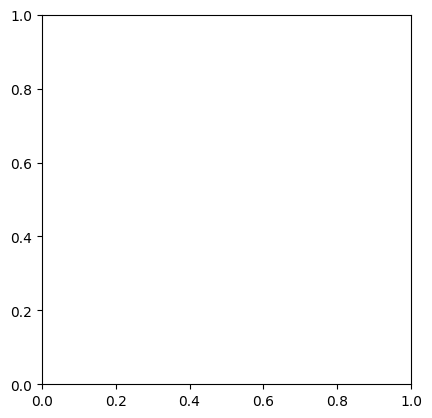

In [20]:
# New outputs from crop simulation: Moisture reduction factor (fc2)

# Perennials are considered no limitation due to moisture deficit/ This function is exclusive to non-perennials.
# No need to run this cell for perennials.
fc2 = aez.getMoistureReductionFactor()

"""visualizing the result"""
plt.imshow(fc2, vmin= 0, vmax = 1)
plt.colorbar()
plt.title('fc2 (Moisture limited reduction factor)')
plt.show()


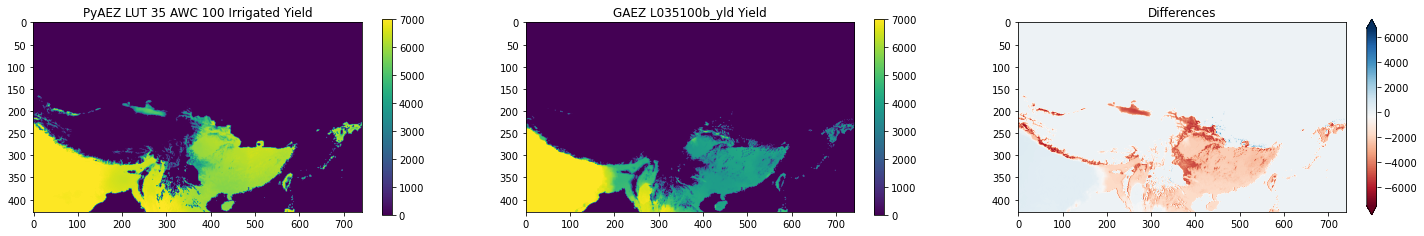

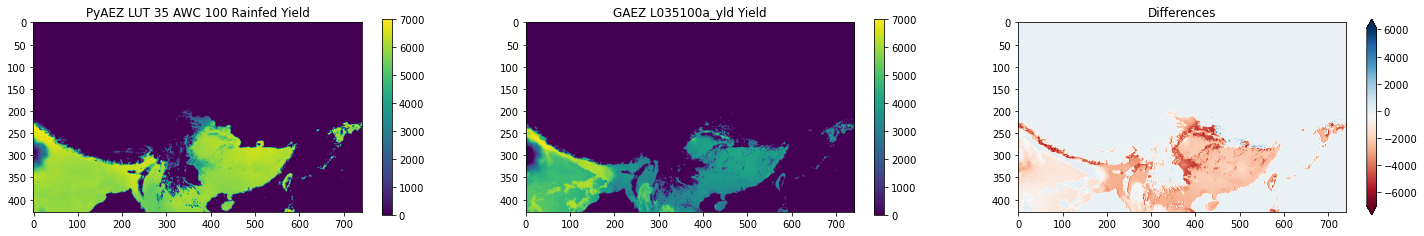

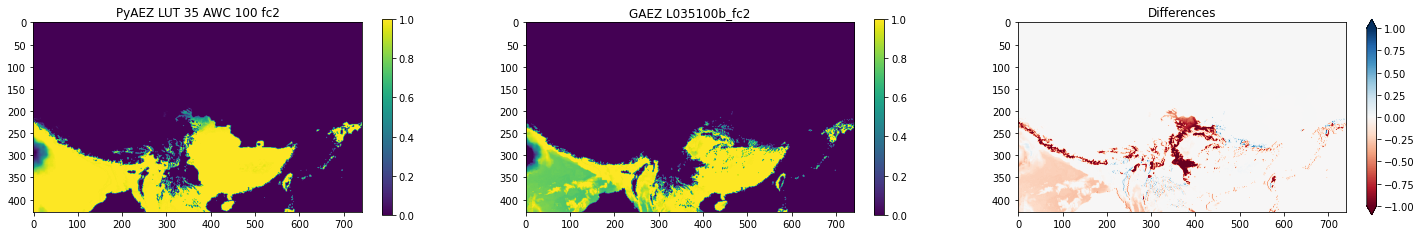

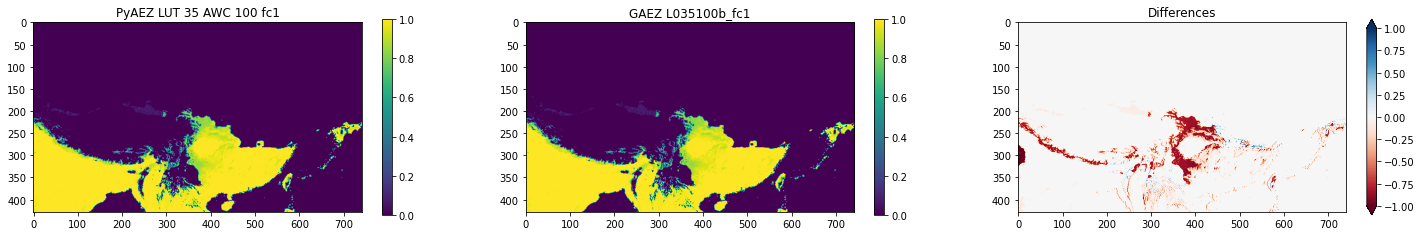

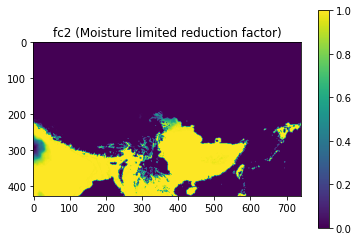

In [ ]:
# '''save result'''

obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_yield_rain.tif', yield_map_rain)
obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_yield_irr.tif', yield_map_irr)

obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_starting_date_rain.tif', starting_date_rain)
obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_starting_date_irr.tif', starting_date_irr)

# obj_utilities.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\CropSuitability_rain_class.tif',yield_map_rain_class)
# obj_utilities.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\CropSuitability_irr_class.tif',yield_map_irr_class)

In [25]:
# New outputs from crop simulation: Thermal reduction factor (fc1)

# Perennial will provide a python list of 2D np arrays as [fc1_rainfed, fc2_irrigated]
fc1 = aez.getThermalReductionFactor()

if type(fc1) == list:
    fc1_rain = fc1[0] # fc1 for rainfed conditions
    fc1_irr = fc1[1] # fc1 for irrigated conditions

    """visualizing the result"""
    plt.imshow(fc1_rain, vmin= 0, vmax = 1)
    plt.colorbar()
    plt.title('Thermal reduction factor rainfed')
    plt.show()

    """visualizing the result"""
    plt.imshow(fc1_irr, vmin= 0, vmax = 1)
    plt.colorbar()
    plt.title('Thermal reduction factor irrigated')
    plt.show()
else:
    """visualizing the result"""
    plt.imshow(fc1, vmin= 0, vmax = 1)
    plt.colorbar()
    plt.title('Thermal reduction factor (both conditions)')
    plt.show()

In [ ]:
"""Saving the thermal reduction factor as rasters"""

if type(fc1)==list:
    obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_fc1_rain.tif',fc1[0])
    obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_fc1_irr.tif',fc1[1])
else:
    obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_fc1.tif',fc1)



In [ ]:
"""Saving the moisture reduction factor as raster. Skip this for perennials"""

# obj_util.saveRaster(r'.\data_input\LAO_Admin.tif', r'.\data_output\NB2\sugar_fc2.tif',fc2)

<hr>

### END OF MODULE 2: CROP SIMULATION

<hr>